# 3 - Analysis of DVL Data
Finally, we want to evalute the quality of the glider's merged dataset, with creating velocity profiles as the end goal

In [2]:
import pandas as pd
import xarray as xr
import numpy as np

In [3]:
# load in the merged glider data set (will be using Glider 379 for analysis)

glider = xr.open_dataset("../data/processed/CP05MOAS-GL379.deployment0008.merged.nc")

## *Plotting the track of Glider 379*
Plotting the track 
- ensures that the glider stuck to the preprogrammed waypoints
- shows us which moorings the glider passes by for future comparison

In [4]:
# load in mooring data

moorings = pd.read_csv("../data/raw/mooring_locations.csv")

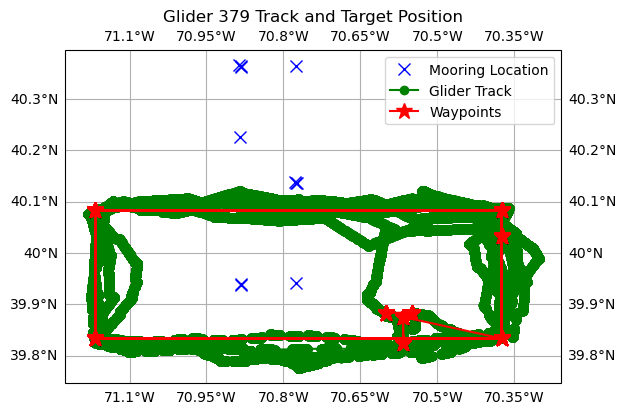

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# get glider data
waypoint_lon = glider['waypoint_lon']
filtered_waypoint_lon = waypoint_lon.where(waypoint_lon != 0.0, drop=True)     # dataset includes waypoints of 0.0, we want to remove these
waypoint_lat = glider['waypoint_lat']
filtered_waypoint_lat = waypoint_lat.where(waypoint_lat != 0.0, drop=True)
track_lon = glider['glider_precise_lon']
track_lat = glider['glider_precise_lat']

# get mooring locations
mooring_lat = moorings['lat']
pioneer_lat = mooring_lat[0:12]     # we only want the moorings associated with the Pioneer Array
mooring_lon = moorings['lon']
pioneer_lon = mooring_lon[0:12]

# plotting track
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Glider 379 Track and Target Position')

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

ax.plot(pioneer_lon, pioneer_lat, marker='x', markersize = 8, linestyle='None', color='blue', label='Mooring Location', transform=ccrs.PlateCarree())

ax.plot(track_lon, track_lat, color='green', marker='o', label='Glider Track', transform=ccrs.PlateCarree())
ax.plot(filtered_waypoint_lon, filtered_waypoint_lat, color='red', marker='*', markersize=12, label='Waypoints', transform=ccrs.PlateCarree())

ax.legend()

plt.show()

## *Subsetting the whole track*
For our analysis, we will be focusing on the northern portion of the track

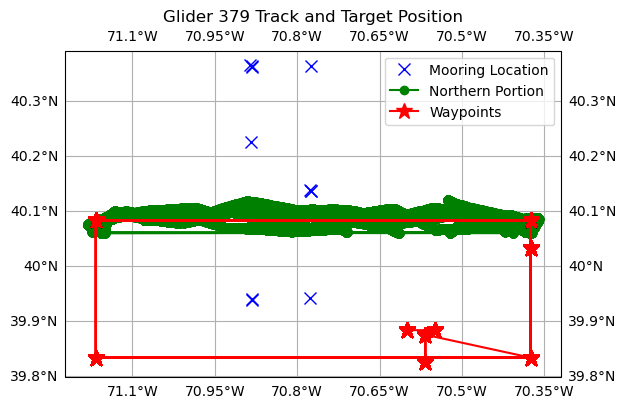

In [12]:
target_lat = 40.09
tolerance = 0.03

# applying latitude mask
mask = abs(glider['glider_precise_lat'] - target_lat) <= tolerance
filtered_track = {
    var: glider[var].where(mask, drop=True)
    for var in ['glider_precise_lon', 'glider_precise_lat']
}

# plotting the subset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Glider 379 Track and Target Position')

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

ax.plot(pioneer_lon, pioneer_lat, marker='x', markersize = 8, linestyle='None', color='blue', label='Mooring Location', transform=ccrs.PlateCarree())

ax.plot(filtered_track['glider_precise_lon'], filtered_track['glider_precise_lat'], color='green', marker='o', label='Northern Portion', transform=ccrs.PlateCarree())
ax.plot(filtered_waypoint_lon, filtered_waypoint_lat, color='red', marker='*', markersize=12, label='Waypoints', transform=ccrs.PlateCarree())

ax.legend()

plt.show()

## *Getting one segment and one dive*
Throughout the northern portion, the glider travels east and west mutiple times. We define each completed east-west transect as a segment.

We will focus on one of these segments, which are composed of numerous dives. Analysis will eventually continue on a dive-by-dive basis.

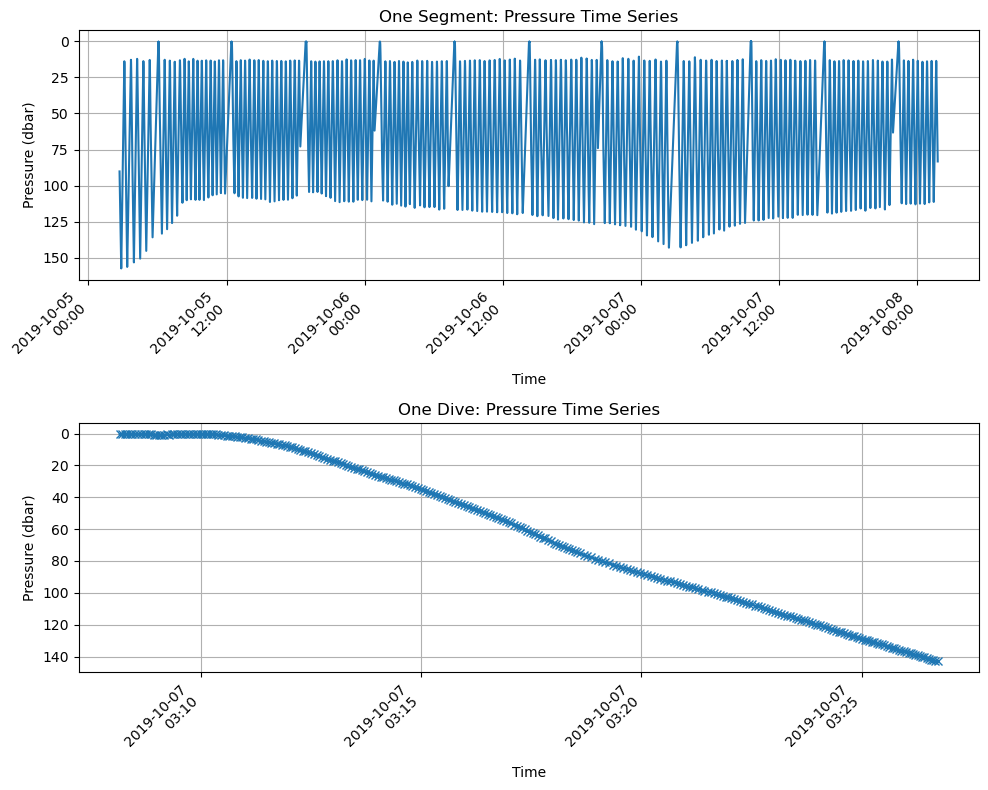

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Subset the data by segment date
segment_start = '2019-10-05T02:42:00'
segment_end = '2019-10-08T01:47:00'
segment_subset = glider.sel(time=slice(segment_start, segment_end))

# Extract time and the variable you want to plot
segment_times = pd.to_datetime(segment_subset['time'].values).to_pydatetime()
segment_pressure = segment_subset['non_zero_pressure'].values

# getting a time of one dive
dive_start = '2019-10-07T03:05:00'
dive_end = '2019-10-07T03:35:00'
dive_subset = glider.sel(time=slice(dive_start, dive_end))

# extracting dive data
dive_times = pd.to_datetime(dive_subset['time'].values).to_pydatetime()
dive_pressure = dive_subset['non_zero_pressure'].values


# plotting both the segment and dive
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Segment
c1 = ax1.plot(segment_times, segment_pressure)
ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel('Time')
ax1.set_title('One Segment: Pressure Time Series')
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(True)

# Dive
c2 = ax2.plot(dive_times, dive_pressure, marker = 'x', markersize = 6)
ax2.set_xlabel('Time')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_title('One Dive: Pressure Time Series')
ax2.invert_yaxis()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True)

plt.tight_layout()
plt.show()


## *Investigating Quality Control Parameters*
Now that we have a single dive from the glider, we can begin plotting various quality control parameters over the dive. This will allow us to select our threshold for the data.

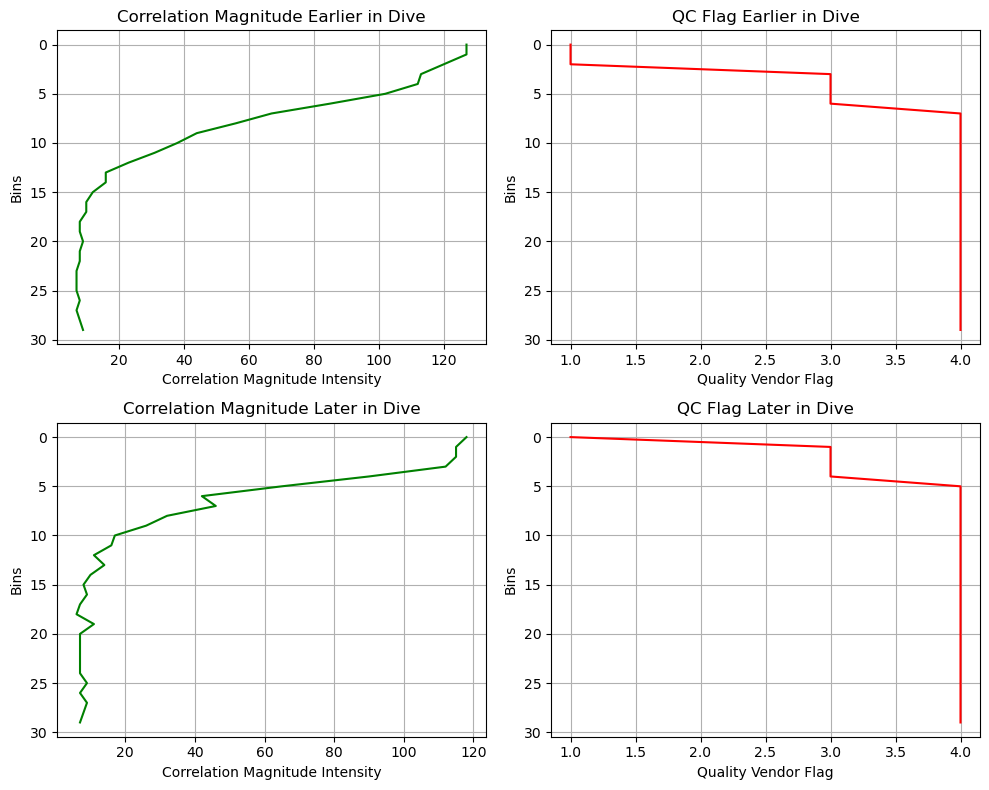

In [50]:
# selecting a data point during the dive

target_time1 = '2019-10-07T03:13:00'         # data from near the beginning of the dive
dive_profile1 = dive_subset.sel(time=target_time1, method='nearest')

target_time2 = '2019-10-07T03:21:00'
dive_profile2 = dive_subset.sel(time=target_time2, method='nearest')

# extracting data from this data point (selecting the correlation magnitude beam and the QC vendor flag)

bins1 = dive_profile1['bin'].values
correlation1 = dive_profile1['correlation_magnitude_beam2'].values
QC1 = dive_profile1['vendor_qc_flag'].values

bins2 = dive_profile2['bin'].values
correlation2 = dive_profile2['correlation_magnitude_beam2'].values
QC2 = dive_profile2['vendor_qc_flag'].values

# plotting the parameters against bins
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

c1 = ax1.plot(correlation1, bins1, color='green')
ax1.set_ylabel('Bins')
ax1.set_xlabel('Correlation Magnitude Intensity')
ax1.set_title('Correlation Magnitude Earlier in Dive')
ax1.invert_yaxis()
ax1.grid(True)

c2 = ax2.plot(QC1, bins1, color='red')
ax2.set_xlabel('Quality Vendor Flag')
ax2.set_ylabel('Bins')
ax2.set_title('QC Flag Earlier in Dive')
ax2.invert_yaxis()
ax2.grid(True)

c3 = ax3.plot(correlation2, bins2, color='green')
ax3.set_ylabel('Bins')
ax3.set_xlabel('Correlation Magnitude Intensity')
ax3.set_title('Correlation Magnitude Later in Dive')
ax3.invert_yaxis()
ax3.grid(True)

c4 = ax4.plot(QC2, bins2, color='red')
ax4.set_xlabel('Quality Vendor Flag')
ax4.set_ylabel('Bins')
ax4.set_title('QC Flag Later in Dive')
ax4.invert_yaxis()
ax4.grid(True)

plt.tight_layout()
plt.show()

Correlation magnitude intensities below 50 or 60 dB are indicative of bad data. QC vendor flags of 4 are indicative of bad data, flags of 3 are suspect, and flags of 1 indicate good data.

These graphs show that
- Correlation magnitude intensities drop around the same bin as the QC flag goes to 4
- Less good data is available later in dives

From these graphs, we determined our quality control threshold: <ins>*masking any data with a QC vendor flag of 4*</ins>

## *Applying the QC Mask to the Velocity Data*
Now that we established our threshold, we want to mask out any velocity measurements associated with bad data.

To do so, we would need to copy our original dataset and apply the mask.

In [ ]:
# select glider dataset

GL379 = xr.open_dataset("../processed/CP05MOAS-GL379.deployment0008.merged.nc")

# determine mask
qc_mask = GL379['vendor_qc_flag'] !=4

# apply mask to northward and eastward velocities
NV_clean_nan = GL379['northward_seawater_velocity'].where(qc_mask)
EV_clean_nan = GL379['eastward_seawater_velocity'].where(qc_mask)

# copy original dataset, filtering out bad velocity data
clean_velocities = GL379.copy()

clean_velocities['northward_seawater_velocity'] = NV_clean_nan
clean_velocities['eastward_seawater_velocity'] = EV_clean_nan

# create a new, "clean" dataset
clean_velocities.to_netcdf("../data/processed/CP05MOAS-GL379.dep8.clean_velocities.nc")

## *Creating Depth-Averaged Velocity Profiles*
With our quality-controlled dataset, we can go ahead and begin creating velocity profiles from the glider.

This is a multi-step process which includes:
- Ploting good velocity measurements over dives and segments (chosing dive nearest to mooring for eventual comparison)
- Grouping data into bins of equal depth
- Calculating the means and standard deviations in the bins
- Plotting the velocities against depth

In [66]:
# open "cleaned" dataset

clean_glider = xr.open_dataset("../data/processed/CP05MOAS-GL379.dep8.clean_velocities.nc")

In [67]:
# finding the average distance the glider is to the mooring

# load in glider coordinates
glider_lat = clean_glider['glider_precise_lat'].values
glider_lon = clean_glider['glider_precise_lon'].values

# Set a target to the mooring's location
lat_target = 40.0983173
lon_target = -70.8833011

# Compute Euclidean distance (approximate, good for small areas)
distance = np.sqrt((glider_lat - lat_target)**2 + (glider_lon - lon_target)**2)
flat_distance = distance.flatten()
mean_distance = flat_distance.mean()

# finding the time the glider is nearest to the mooring

# Find the index where the glider is closest to the mooring
closest_index = np.argmin(distance)

# Get the corresponding time
closest_time = clean_glider['time'].values[closest_index]

print(f"The glider was closest to the mooring at {closest_time}")
print(f"The glider was on average {mean_distance:.3f} meters away from the mooring")

The glider was closest to the mooring at 2019-10-23T09:56:35.320000000
The glider was on average 0.350 meters away from the mooring


/tmp/ipykernel_14780/2261368052.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax1.pcolormesh(time_grid, actual_depth_dive, masked_nan_NV, cmap='Greens_r', shading='auto')


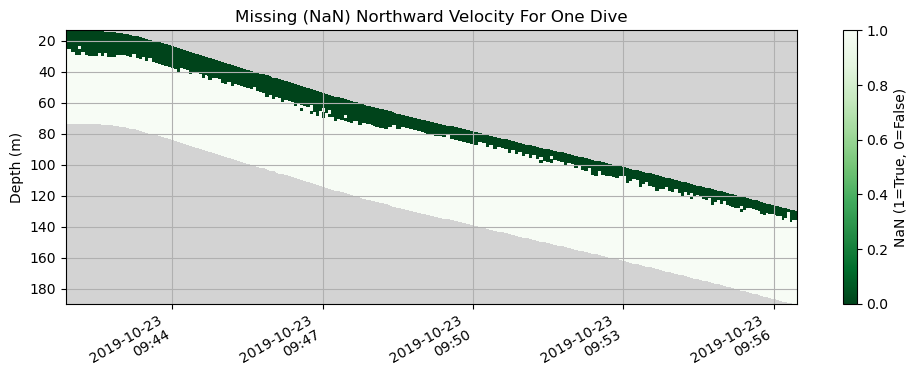

In [69]:
# Plotting good data as the glider passes over the mooring

start_dive = '2019-10-23T09:35:00'
end_dive = '2019-10-23T10:05:00'
subset_dive = clean_glider.sel(time=slice(start_dive, end_dive))

times_dive = pd.to_datetime(subset_dive['time'].values).to_pydatetime()

# Extracting other data
NV_dive = subset_dive['northward_seawater_velocity'].values
EV_dive = subset_dive['eastward_seawater_velocity'].values
pressure_dive = subset_dive['non_zero_pressure'].values
depth_dive = subset_dive['depth_from_pressure'].values

# Create 30 bins, each bin 2 meters deep
bin_depths_dive = np.arange(1, 60, 2)

# Calculate actual depth from bins and depth from pressure values
actual_depth_dive = depth_dive[:, np.newaxis] + bin_depths_dive[np.newaxis, :]

# Original NaN masks
nan_NV = np.isnan(NV_dive)
nan_EV = np.isnan(EV_dive)

# Copy the original mask to modify
nan_mask_corrected = nan_NV.copy()

# Iterate over time steps (columns)
for i in range(nan_NV.shape[1]):
    col = nan_NV[:, i]
    
    # Find first NaN index in the column
    nan_indices = np.where(col)[0]
    
    if nan_indices.size > 0:
        first_nan_idx = nan_indices[0]
        
        # Mask everything *deeper* (i.e., after the first NaN)
        nan_mask_corrected[first_nan_idx+1:, i] = True

# Apply bottom hit masking
final_mask = np.logical_or(nan_mask_corrected, actual_depth_dive > 140)

# Define depth threshold
max_depth_dive = 140  # meters

# Create a mask for depths > 160 meters
bottom_mask_dive = actual_depth_dive > max_depth_dive

# Combine with original NaN mask: treat everything below 160 as missing
masked_nan_NV = np.logical_or(nan_NV, bottom_mask_dive)

# Convert time to matplotlib format
time_num = mdates.date2num(times_dive)

# Creating a time grid to follow glider dive
time_grid = np.repeat(time_num[:, np.newaxis], NV_dive.shape[1], axis=1)

# Creating plots
fig, ax1 = plt.subplots(figsize=(10, 4))

c = ax1.pcolormesh(time_grid, actual_depth_dive, masked_nan_NV, cmap='Greens_r', shading='auto')
ax1.invert_yaxis()
ax1.set_facecolor('lightgray')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Missing (NaN) Northward Velocity For One Dive')
fig.colorbar(c, ax=ax1, label='NaN (1=True, 0=False)')

# Format time axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.grid(True)
plt.show()

The glider picks up bottom-hit data as it reaches the end of the dive. Bottom-hit data is not trustworty data, and needs to be masked out in order to accurately calculate our velocity profiles. 

/tmp/ipykernel_14780/4197626901.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c1 = ax1.pcolormesh(time_grid, actual_depth_dive, NV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
/tmp/ipykernel_14780/4197626901.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c2 = ax2.pcolormesh(time_grid, actual_depth_dive, EV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)


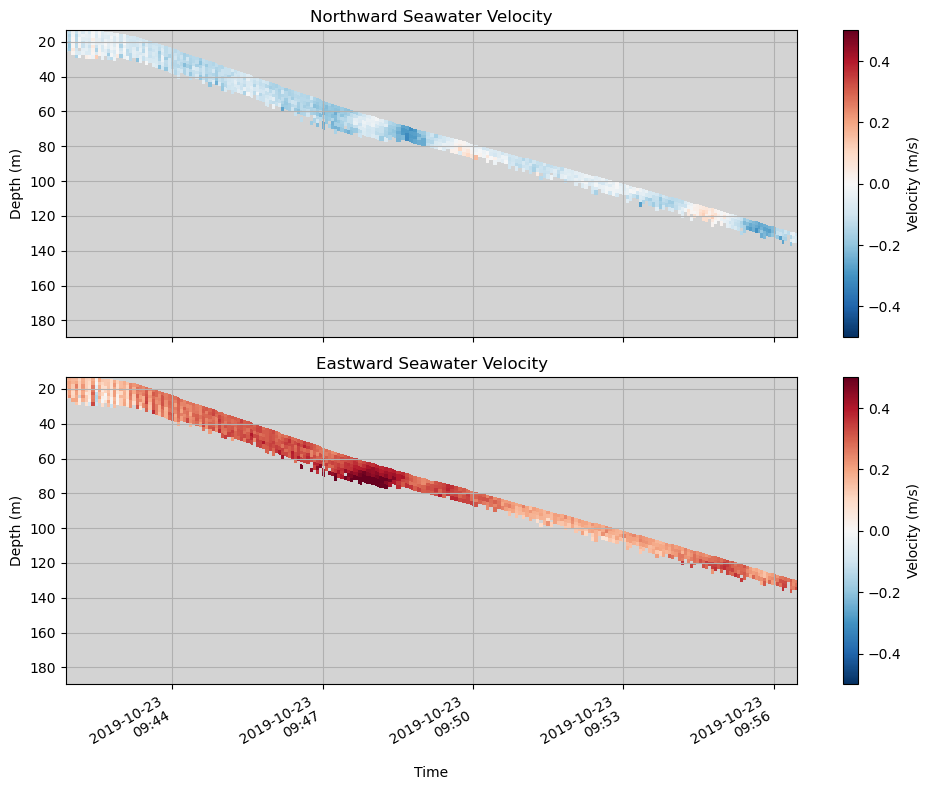

In [70]:
# plotting the velocity values of the dive

# Apply depth mask to velocities
NV_masked = np.where(actual_depth_dive <= max_depth_dive, NV_dive, np.nan)
EV_masked = np.where(actual_depth_dive <= max_depth_dive, EV_dive, np.nan)

# Plotting velocities
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
vmax = 0.5
vmin = -0.5
# Northward velocity
c1 = ax1.pcolormesh(time_grid, actual_depth_dive, NV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
ax1.set_ylabel('Depth (m)')
ax1.set_title('Northward Seawater Velocity')
fig.colorbar(c1, ax=ax1, label='Velocity (m/s)')
ax1.invert_yaxis()
ax1.grid(True)
ax1.set_facecolor('lightgray')

# Eastward velocity
c2 = ax2.pcolormesh(time_grid, actual_depth_dive, EV_masked, cmap='RdBu_r', shading='auto', vmin = vmin, vmax = vmax)
ax2.set_xlabel('Time')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Eastward Seawater Velocity')
fig.colorbar(c2, ax=ax2, label='Velocity (m/s)')
ax2.invert_yaxis()
ax2.grid(True)
ax2.set_facecolor('lightgray')

# Time formatting
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [72]:
# flatten values
depth_flat_dive = actual_depth_dive.flatten()
north_vel_flat_dive = NV_dive.flatten()
east_vel_flat_dive = EV_dive.flatten()

# apply NaN filter
valid_mask = ~np.isnan(north_vel_flat_dive) & ~np.isnan(east_vel_flat_dive) & ~np.isnan(depth_flat_dive)

depth_valid_dive = depth_flat_dive[valid_mask]
north_valid_dive = north_vel_flat_dive[valid_mask]
east_valid_dive = east_vel_flat_dive[valid_mask]

# define bins and bin centers
bin_edges_dive = np.arange(0, 140, 4)  # binning every 4 meters to match mooring data
bin_centers_dive = (bin_edges_dive[:-1] + bin_edges_dive[1:]) / 2

# Bin depths
depth_bins_valid_dive = pd.cut(depth_valid_dive, bins=bin_edges_dive)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_dive = pd.DataFrame({'depth_bin': depth_bins_valid_dive, 'velocity': north_valid_dive})
mean_north_dive = df_north_dive.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_dive = df_north_dive.groupby('depth_bin', observed=False)['velocity'].std()

df_east_dive = pd.DataFrame({'depth_bin': depth_bins_valid_dive, 'velocity': east_valid_dive})
mean_east_dive = df_east_dive.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_dive = df_east_dive.groupby('depth_bin', observed=False)['velocity'].std()


# To align with bin centers:
north_profile_dive = mean_north_dive.values
east_profile_dive = mean_east_dive.values
std_north_profile_dive = std_north_dive.values
std_east_profile_dive = std_east_dive.values

From our velocity plots, we grouped our velocity measurements by depth and then stored values in a new dataframe. The means and standard deviations of velocity values was then calculated by depth in these new data frames.

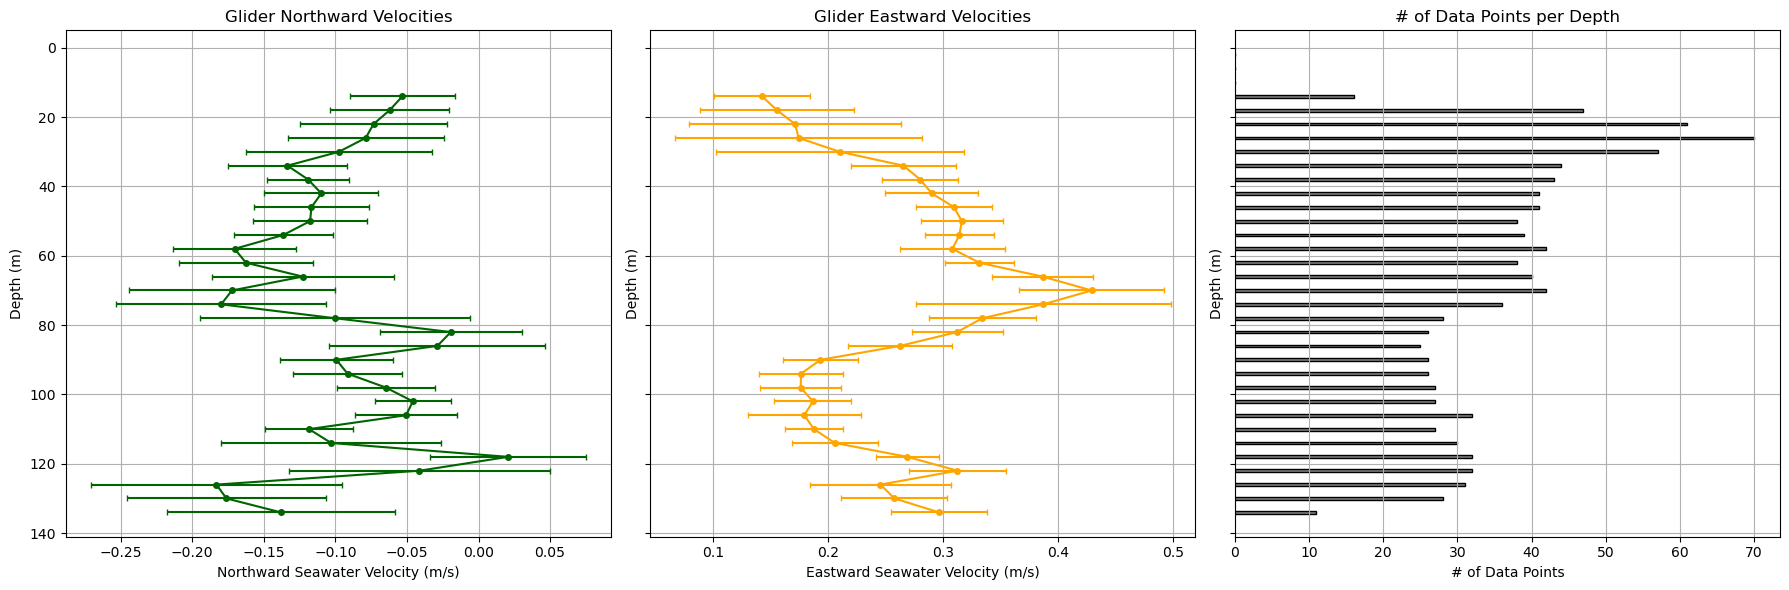

In [75]:
import matplotlib.pyplot as plt

counts_per_bin_dive, _ = np.histogram(depth_valid_dive, bins=bin_edges_dive)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
c1 = ax1.errorbar(north_profile_dive, bin_centers_dive, xerr=std_north_profile_dive, label='Northward Velocities', color='darkgreen', fmt='-o', capsize=2, markersize=4)
ax1.invert_yaxis()
ax1.set_xlabel('Northward Seawater Velocity (m/s)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Glider Northward Velocities')
ax1.grid(True)

c2 = ax2.errorbar(east_profile_dive, bin_centers_dive, xerr=std_east_profile_dive, label='Eastward Velocities', color='orange', fmt='-o', capsize=2, markersize=4)
ax2.invert_yaxis()
ax2.set_xlabel('Eastward Seawater Velocity (m/s)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Glider Eastward Velocities')
ax2.grid(True)

c3 = ax3.barh(bin_centers_dive, counts_per_bin_dive, color='gray', edgecolor='black')
ax3.invert_yaxis()
ax3.set_xlabel('# of Data Points')
ax3.set_ylabel('Depth (m)')
ax3.set_title('# of Data Points per Depth')

plt.grid(True)
plt.tight_layout()
plt.show()

A histogram of data points per depth was plotted in order to justify using single dives for scientific purposes

In [76]:
# calculating velocity profiles for entire segments

# selecting a segment
start_segment = '2019-10-05T02:42:00'
end_segment = '2019-10-08T01:47:00'
subset_segment = clean_glider.sel(time=slice(start_segment, end_segment))

# extracting other data
NV_segment = subset_segment['northward_seawater_velocity']
EV_segment = subset_segment['eastward_seawater_velocity']
depth_segment = subset_segment['depth_from_pressure'].values

# creating 30 bins, each bin 2 meters deep
bin_depths_segment = np.arange(1, 60, 2)

# calculating depth from bin depths and depth from pressure
actual_depth_segment = depth_segment[:, np.newaxis] + bin_depths_segment[np.newaxis, :]

bottom_hit_depths_segment = np.full(NV_segment.shape[0], np.inf)  # initialize with large depth
max_depth_segment = np.nanmax(actual_depth_segment)

# creating NaN mask for velocities
nan_NV_segment = np.isnan(NV_segment)
nan_EV_segment = np.isnan(EV_segment)

# filtering out bottom-hits for entire segment
for t in range(NV_segment.shape[0]):
    # Find indices where NV_segment is NaN (bottom hit)
    nan_indices_segment = np.where(nan_NV_segment[t])[0]
    if nan_indices_segment.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_segment = actual_depth_segment[t, nan_indices_segment]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_segment[t] = nan_depths_segment.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_segment = np.where(np.isinf(bottom_hit_depths_segment), max_depth_segment, bottom_hit_depths_segment)

# Initialize bottom mask same shape as actual_depth6
bottom_mask_dynamic_segment = np.zeros_like(actual_depth_segment, dtype=bool)

for t in range(actual_depth_segment.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_segment[t] = actual_depth_segment[t] > bottom_hit_depths_segment[t]

# Combine with original NaN mask
masked_nan_dynamic_segment = np.logical_or(nan_NV_segment, bottom_mask_dynamic_segment)

# applying mask to northward and eastward velocities
NV_segment_masked = NV_segment.where(~masked_nan_dynamic_segment)  # keep values where mask is False
EV_segment_masked = EV_segment.where(~masked_nan_dynamic_segment)

In [78]:
# flatten values
depth_flat_segment = actual_depth_segment.flatten()
north_vel_flat_segment = NV_segment_masked.values.flatten()
east_vel_flat_segment = EV_segment_masked.values.flatten()

# apply NaN filter
valid_mask_segment = ~np.isnan(north_vel_flat_segment) & ~np.isnan(east_vel_flat_segment) & ~np.isnan(depth_flat_segment)

depth_valid_segment = depth_flat_segment[valid_mask_segment]
north_valid_segment = north_vel_flat_segment[valid_mask_segment]
east_valid_segment = east_vel_flat_segment[valid_mask_segment]

# define bins and bin centers
bin_edges_segment = np.arange(0, 160, 2)  # From 0 to 60m, every 2 meters
bin_centers_segment = (bin_edges_segment[:-1] + bin_edges_segment[1:]) / 2

# Bin depths
depth_bins_valid_segment = pd.cut(depth_valid_segment, bins=bin_edges_segment)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_segment = pd.DataFrame({'depth_bin': depth_bins_valid_segment, 'velocity': north_valid_segment})
mean_north_segment = df_north_segment.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_segment = df_north_segment.groupby('depth_bin', observed=False)['velocity'].std()

df_east_segment = pd.DataFrame({'depth_bin': depth_bins_valid_segment, 'velocity': east_valid_segment})
mean_east_segment = df_east_segment.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_segment = df_east_segment.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_segment = mean_north_segment.values
east_profile_segment = mean_east_segment.values
stdE_profile_segment = std_east_segment.values
stdN_profile_segment = std_north_segment.values

In [83]:
# getting # of data points per depth
bin_edges_segment = np.arange(0, 160, 2)  # From 0 to 60m, every 2 meters
bin_centers_segment = (bin_edges_segment[:-1] + bin_edges_segment[1:]) / 2
counts_per_bin_segment, _ = np.histogram(depth_valid_segment, bins=bin_edges_segment)

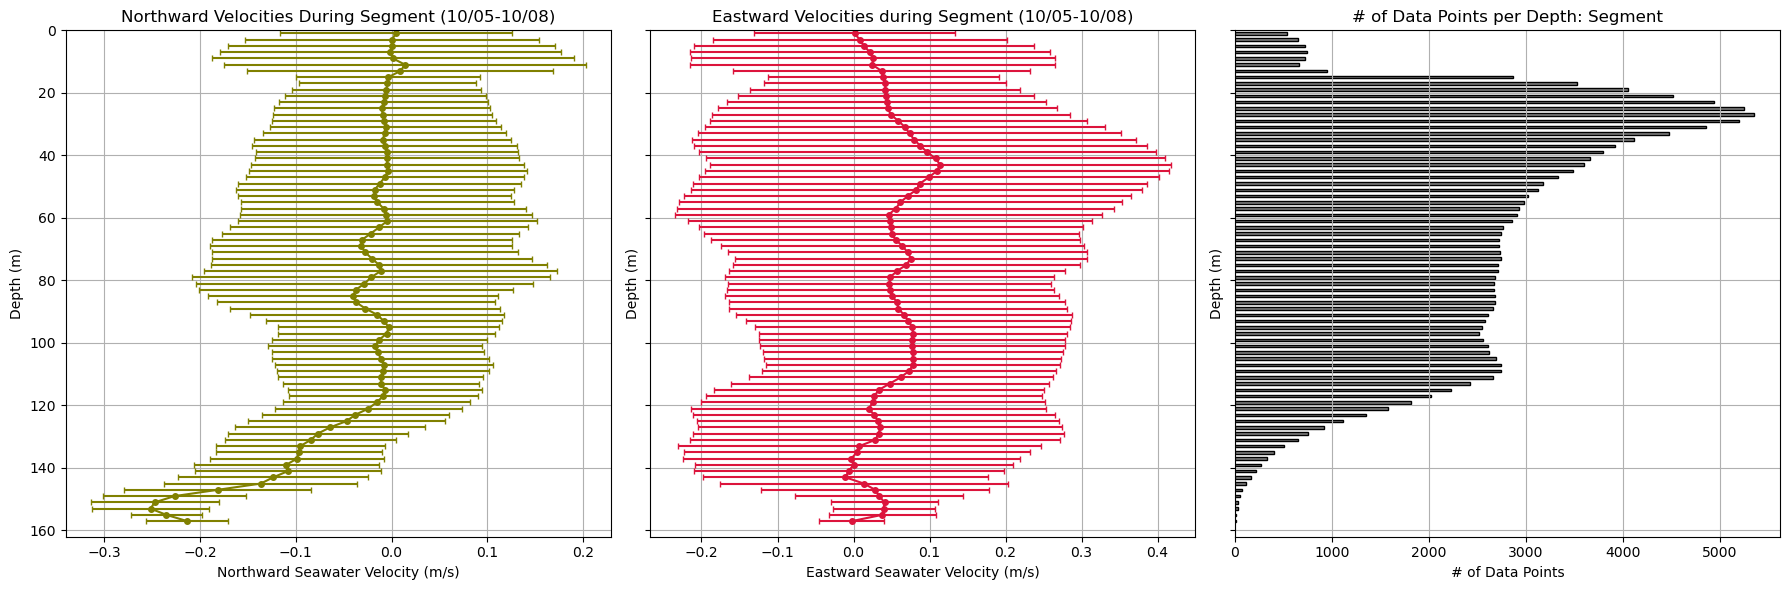

In [84]:
# plotting profiles

import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
c1 = ax1.errorbar(north_profile_segment, bin_centers_segment, xerr=stdN_profile_segment, label='Northward', color='olive', fmt='-o', capsize=2, markersize=4)
ax1.invert_yaxis()
ax1.set_xlabel('Northward Seawater Velocity (m/s)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Northward Velocities During Segment (10/05-10/08)')
ax1.grid(True)

c2 = ax2.errorbar(east_profile_segment, bin_centers_segment, xerr=stdE_profile_segment, label='Eastward', color='crimson', fmt='-o', capsize=2, markersize=4)
ax2.invert_yaxis()
ax2.set_xlabel('Eastward Seawater Velocity (m/s)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Eastward Velocities during Segment (10/05-10/08)')
ax2.grid(True)

c3 = ax3.barh(bin_centers_segment, counts_per_bin_segment, color='gray', edgecolor='black')
ax3.invert_yaxis()
ax3.set_xlabel('# of Data Points')
ax3.set_ylabel('Depth (m)')
ax3.set_ylim(162, 0)
ax3.set_title('# of Data Points per Depth: Segment')

plt.grid(True)
plt.tight_layout()
plt.show()

## *Comparing Glider Profiles to Mooring Profiles*
In order to validate our glider velocity profiles, we need to compare them to the nearest mooring.

The glider passes over the Central Offshore Profiler Mooring on October 23rd, 2019 during one of its dives. This is the dive we plotted above. The mooring creates profiles every 30 minutes, so we will be comparing the glider profile from the dive with the closest mooring profile. This temporal inconsistency causes differences that will be explored later.

We will be applying the same quality control to the mooring data to ensure accurate comparisons.

In [87]:
# load in mooring data

# mooring data downloaded from OOINet
mooring = xr.open_dataset("../data/raw/deployment0013_CP02PMCO-RII01-02-ADCPTG010-recovered_inst-adcp_velocity_earth_20191023T090000-20191023T100000.nc")

In [ ]:
# applying QC mask to mooring data

qc_mask_MCO = ~CPO2PMCO['roll_qartod_results'].isin([4, 9])

MCO_NV_clean = CPO2PMCO['northward_seawater_velocity'].where(qc_mask_MCO)
MCO_EV_clean = CPO2PMCO['eastward_seawater_velocity'].where(qc_mask_MCO)

masked_velocities = CPO2PMCO.copy()

masked_velocities['northward_seawater_velocity'] = MCO_NV_clean
masked_velocities['eastward_seawater_velocity'] = MCO_EV_clean

# creating new dataset with "clean" velocities
masked_velocities.to_netcdf("../data/processed/CP02PMCO.dep13.masked_velocities.nc")

In [89]:
# open quality-controlled dataset

masked_MCO = xr.open_dataset("../data/processed/CP02PMCO.dep13.masked_velocities.nc")

In [90]:
# Taking data from 3rd set of observations (which is the same as 10 AM)
MCO_NV = masked_MCO['northward_seawater_velocity'].isel(obs=2)
MCO_EV = masked_MCO['eastward_seawater_velocity'].isel(obs=2)
MCO_depth = masked_MCO['bin_depths'].isel(obs=2)

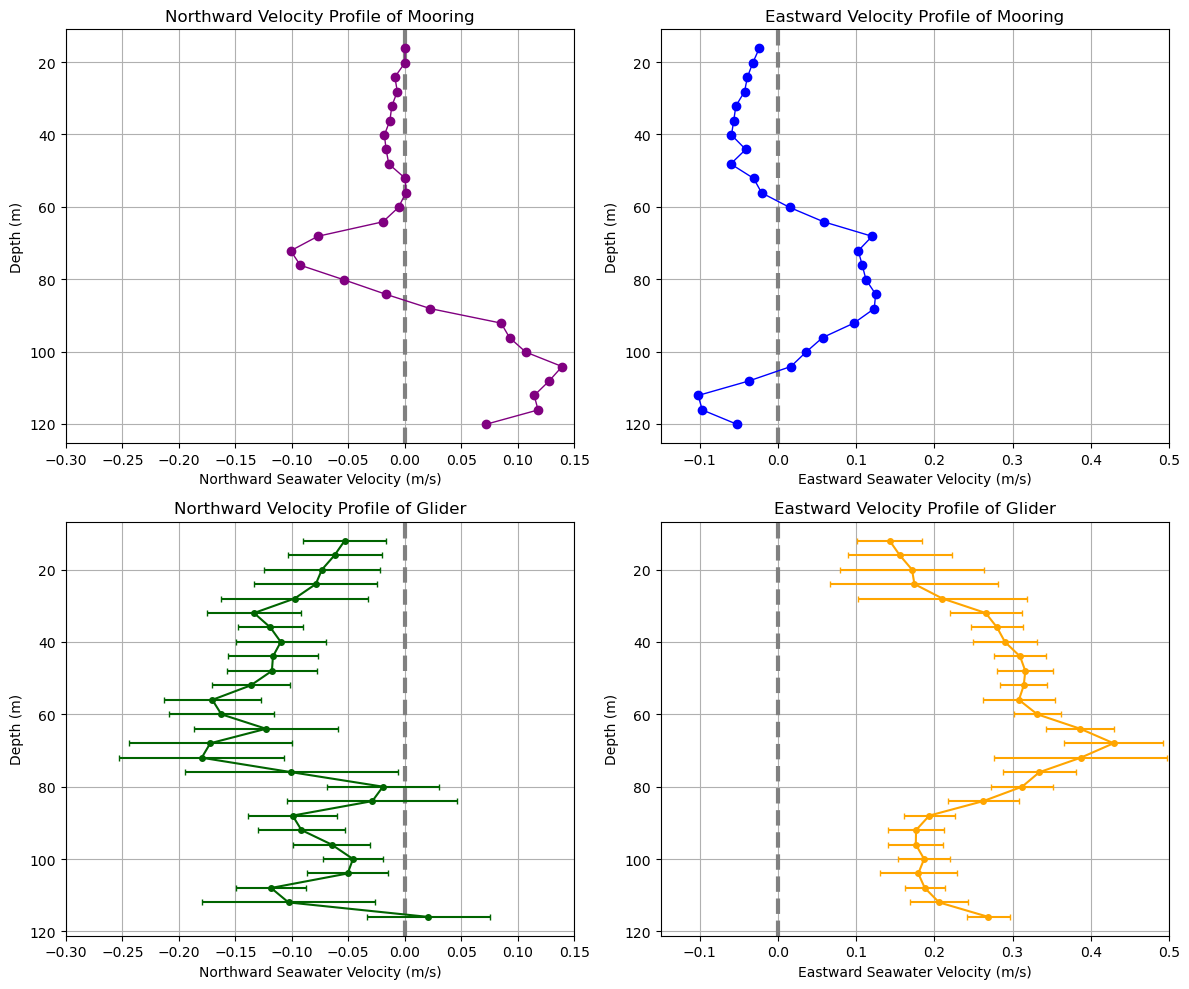

In [96]:
# glider and mooring profiles

import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

for ax in [ax1, ax2, ax3, ax4]:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=3)

c1 = ax1.plot(MCO_NV[0:27], MCO_depth[0:27], color='purple', linestyle='-', marker='o', lw = 1, markersize=6)
ax1.set_xlabel("Northward Seawater Velocity (m/s)")
ax1.set_xlim(-0.3, 0.15)
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()
ax1.set_title("Northward Velocity Profile of Mooring")
ax1.grid(True) 

c2 = ax2.plot(MCO_EV[0:27], MCO_depth[0:27], color='blue', linestyle='-', marker='o', lw=1, markersize=6)
ax2.set_xlabel("Eastward Seawater Velocity (m/s)")
ax2.set_xlim(-0.15, 0.5)
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()
ax2.set_title("Eastward Velocity Profile of Mooring")
ax2.grid(True)

c3 = ax3.errorbar(north_profile_dive[0:30], bin_edges_dive[0:30], xerr=std_north_profile_dive[0:30], label='Northward Velocities', color='darkgreen', fmt='-o', capsize=2, markersize=4)
ax3.invert_yaxis()
ax3.set_xlabel('Northward Seawater Velocity (m/s)')
ax3.set_xlim(-0.3, 0.15)
ax3.set_ylabel('Depth (m)')
ax3.set_title('Northward Velocity Profile of Glider')
ax3.grid(True)

c4 = ax4.errorbar(east_profile_dive[0:30], bin_edges_dive[0:30], xerr=std_east_profile_dive[0:30], label='Eastward Velocities', color='orange', fmt='-o', capsize=2, markersize=4)
ax4.invert_yaxis()
ax4.set_xlabel('Eastward Seawater Velocity (m/s)')
ax4.set_xlim(-0.15, 0.5)
ax4.set_ylabel('Depth (m)')
ax4.set_title('Eastward Velocity Profile of Glider')
ax4.grid(True)

plt.tight_layout()
plt.show()

#### *Removing Bottom Track Velocities*
Removing the glider's speed through the water is very important for this comparison, as it removes any bias in the velocities caused by glider motion. Unfortunately, glider speed was inconsistent over the course of dives and segments. For our analysis of the how the bottom-track velocities impact the data, we removed 0.25 m/s from eastward velocity values, while kept northward velocities untouched.

The next step in analysis is to make a difference profile.

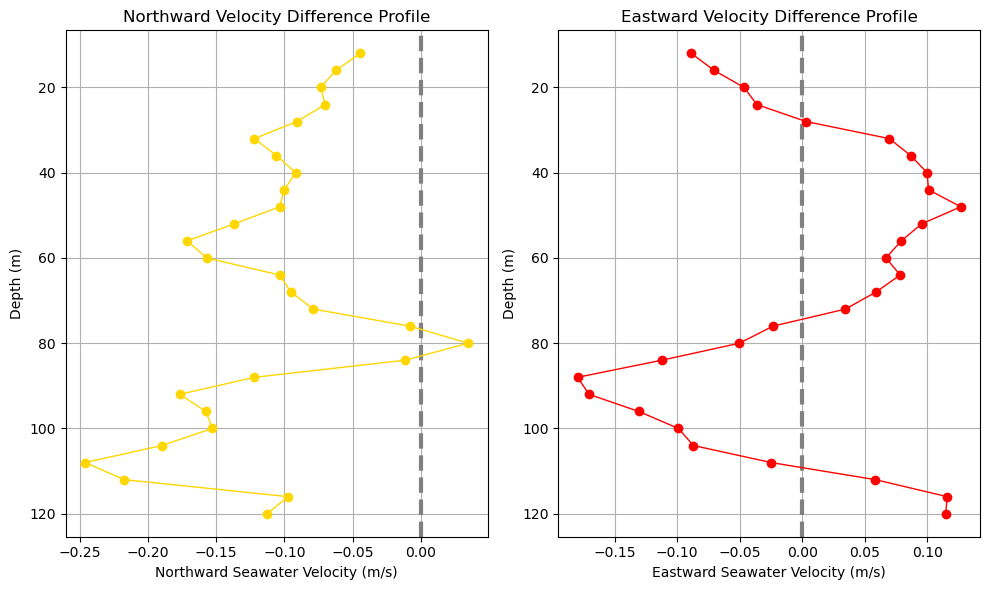

In [115]:
# creating a difference profile

NV_diff = north_profile_dive[1:31] - MCO_NV[0:30][::-1]    # putting mooring values in ascending order
EV_diff = (east_profile_dive[1:31] - 0.25) - MCO_EV[0:30][::-1]

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
for ax in [ax1, ax2]:
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=3)

c1 = ax1.plot(NV_diff, bin_edges_dive[1:31], color='gold', linestyle='-', marker='o', lw = 1, markersize=6)
ax1.set_xlabel("Northward Seawater Velocity (m/s)")
ax1.set_ylabel("Depth (m)")
ax1.invert_yaxis()
ax1.set_title("Northward Velocity Difference Profile")
ax1.grid(True) 

c2 = ax2.plot(EV_diff, bin_edges_dive[1:31], color='red', linestyle='-', marker='o', lw=1, markersize=6)
ax2.set_xlabel("Eastward Seawater Velocity (m/s)")
ax2.set_ylabel("Depth (m)")
ax2.invert_yaxis()
ax2.set_title("Eastward Velocity Difference Profile")
ax2.grid(True)

plt.tight_layout()
plt.show()

**Comparison of the profiles reveals that spatial and temporal differences betweenthe glider and mooring exist. The shapes and characteristics of the instruments are similar, but differences are evident. From this, we infer that the glider has an instrumentation error of roughly 0.05 m/s, which will be applied into the profiles for future analysis.**

## *Evaluating Shelf-Break Frontal Dynamics*
The Pioneer Array resided along the New England Shelf break before being relocated to the Mid Atlantic Bite. The goal of the array was to study shelf-break frontal dynamics and exchange off the shore of New England. 

Using our velocity profiles, we will evaluate frontal processes.

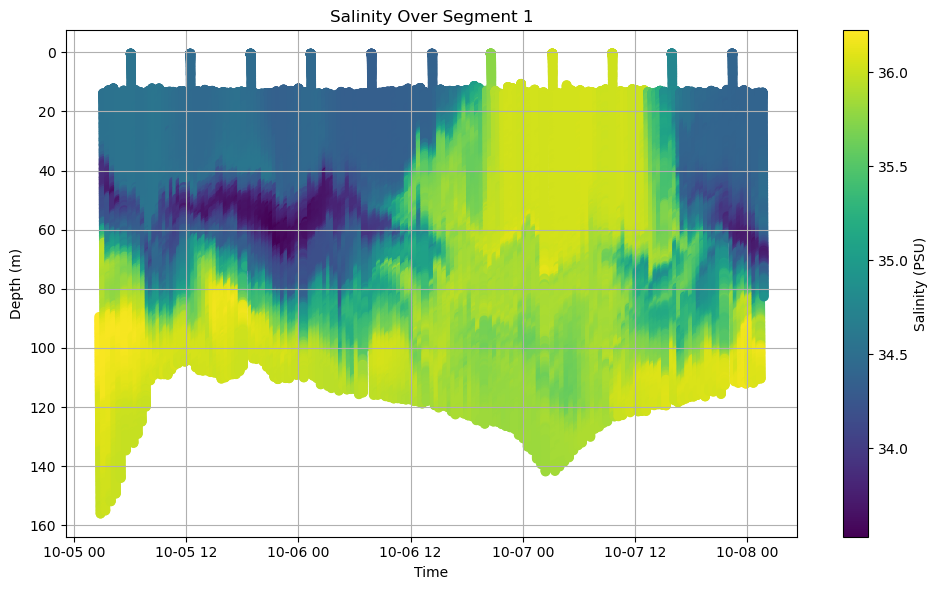

In [117]:
# plotting salinity values over a segment

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# selecting a segment
start_segment = '2019-10-05T02:42:00'
end_segment = '2019-10-08T01:47:00'
subset_segment = clean_glider.sel(time=slice(start_segment, end_segment))

times_segment = pd.to_datetime(subset_segment['time'].values).to_pydatetime()

# extracting salinity data
salinity_segment = subset_segment['ctd_salinity'].values
depth_segment = subset_segment['depth_from_pressure'].values

# plotting 
plt.figure(figsize=(10, 6))
sc = plt.scatter(times_segment, depth_segment, c=salinity_segment, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(sc, label='Salinity (PSU)')
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.title('Salinity Over Segment 1')
plt.tight_layout()
plt.grid(True)
plt.show()

**This particular segment is chosen due to the salt-water intrusion occurring near October 7th. To investigate frontal dynamics, velocity profiles will be made from a 12-hour period during the intrusion event and before the event (when normal vertical structure exists). The comparison of these profiles can potentially tell us about the state of the shelf-break saliity front.**

In [118]:
# creating velocity profiles during the intrusion

salt_start = '2019-10-07T00:00:00'
salt_end = '2019-10-07T12:00:00'
salt_subset = clean_glider.sel(time=slice(salt_start, salt_end))

times_salt = pd.to_datetime(salt_subset['time'].values).to_pydatetime()

# extracting other data
NV_salt = salt_subset['northward_seawater_velocity']
EV_salt = salt_subset['eastward_seawater_velocity']
salinity_salt = salt_subset['ctd_salinity'].values
depth_salt = salt_subset['depth_from_pressure'].values

# 30 bins, each bin 2 meters deep
bin_depths_salt = np.arange(1, 60, 2)

# actual depth follows pressure and 
actual_depth_salt = depth_salt[:, np.newaxis] + bin_depths_salt[np.newaxis, :]

bottom_hit_depths_salt = np.full(NV_salt.shape[0], np.inf)  # initialize with large depth
max_depth_salt = np.nanmax(actual_depth_salt)

# creating NaN mask for velocities
nan_NV_salt = np.isnan(NV_salt)
nan_EV_salt = np.isnan(EV_salt)

# filtering out bottom-hits for entire segment
for t in range(NV_salt.shape[0]):
    # Find indices where NV is NaN (bottom hit)
    nan_indices_salt = np.where(nan_NV_salt[t])[0]
    if nan_indices_salt.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_salt = actual_depth_salt[t, nan_indices_salt]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_salt[t] = nan_depths_salt.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_salt = np.where(np.isinf(bottom_hit_depths_salt), max_depth_salt, bottom_hit_depths_salt)

# Initialize bottom mask same shape as actual_depth
bottom_mask_dynamic_salt = np.zeros_like(actual_depth_salt, dtype=bool)

for t in range(actual_depth_salt.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_salt[t] = actual_depth_salt[t] > bottom_hit_depths_salt[t]

# Combine with original NaN mask
masked_nan_NV_dynamic_salt = np.logical_or(nan_NV_salt, bottom_mask_dynamic_salt)

# Identify diving times
depth_change_salt = np.diff(depth_salt, prepend=np.nan)
is_diving_salt = depth_change_salt > 0

# Expand to full 2D shape to match actual_depth_salt or NV_salt
is_diving_2d_salt = np.repeat(is_diving_salt[:, np.newaxis], NV_salt.shape[1], axis=1)

# Apply combined mask: bottom hit + ascending
combined_mask_salt = np.logical_or(masked_nan_NV_dynamic_salt, ~is_diving_2d_salt)

NV_salt_masked = NV_salt.where(~combined_mask_salt)
EV_salt_masked = EV_salt.where(~combined_mask_salt) - 0.25

# flatten values
depth_flat_salt = actual_depth_salt.flatten()
north_vel_flat_salt = NV_salt_masked.values.flatten()
east_vel_flat_salt = EV_salt_masked.values.flatten()

# apply NaN filter
valid_mask_salt = ~np.isnan(north_vel_flat_salt) & ~np.isnan(depth_flat_salt) & ~np.isnan(east_vel_flat_salt)

depth_valid_salt = depth_flat_salt[valid_mask_salt]
north_valid_salt = north_vel_flat_salt[valid_mask_salt]
east_valid_salt = east_vel_flat_salt[valid_mask_salt]

# define bins and bin centers
bin_edges_salt = np.arange(0, 152, 2)  # From 0 to 60m, every 2 meters
bin_centers_salt = (bin_edges_salt[:-1] + bin_edges_salt[1:]) / 2

# Bin depths
depth_bins_valid_salt = pd.cut(depth_valid_salt, bins=bin_edges_salt)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_salt = pd.DataFrame({'depth_bin': depth_bins_valid_salt, 'velocity': north_valid_salt})
mean_north_salt = df_north_salt.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_salt = df_north_salt.groupby('depth_bin', observed=False)['velocity'].std()

df_east_salt = pd.DataFrame({'depth_bin': depth_bins_valid_salt, 'velocity': east_valid_salt})
mean_east_salt = df_east_salt.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_salt = df_east_salt.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_salt = mean_north_salt.values
stdN_profile_salt = std_north_salt.values

east_profile_salt = mean_east_salt.values
stdE_profile_salt = std_east_salt.values

error_north_salt = np.sqrt((stdN_profile_salt ** 2) +(0.05 ** 2))
error_east_salt = np.sqrt((stdE_profile_salt ** 2) + (0.05 ** 2))

In [119]:
# creating a profile for normal shelf conditions

shelf_start = '2019-10-05T00:00:00'
shelf_end = '2019-10-05T12:00:00'
shelf_subset = clean_glider.sel(time=slice(shelf_start, shelf_end))

times_shelf = pd.to_datetime(shelf_subset['time'].values).to_pydatetime()

# extracting other data
NV_shelf = shelf_subset['northward_seawater_velocity']
EV_shelf = shelf_subset['eastward_seawater_velocity']
salinity_shelf = shelf_subset['ctd_salinity'].values
depth_shelf = shelf_subset['depth_from_pressure'].values

# 30 bins, each bin 2 meters deep
bin_depths_shelf = np.arange(1, 60, 2)

# actual depth follows pressure and 
actual_depth_shelf = depth_shelf[:, np.newaxis] + bin_depths_shelf[np.newaxis, :]

bottom_hit_depths_shelf = np.full(NV_shelf.shape[0], np.inf)  # initialize with large depth
max_depth_shelf = np.nanmax(actual_depth_shelf)

# creating NaN mask for velocities
nan_NV_shelf = np.isnan(NV_shelf)
nan_EV_shelf = np.isnan(EV_shelf)

# filtering out bottom-hits for entire segment
for t in range(NV_shelf.shape[0]):
    # Find indices where NV is NaN (bottom hit)
    nan_indices_shelf = np.where(nan_NV_shelf[t])[0]
    if nan_indices_shelf.size > 0:
        # Get depths where NaNs occur for this time
        nan_depths_shelf = actual_depth_shelf[t, nan_indices_shelf]
        # Minimum depth where bottom hit occurs (shallowest NaN depth)
        bottom_hit_depths_shelf[t] = nan_depths_shelf.min()

# Replace inf with some max depth to avoid masking good data when no bottom hit
bottom_hit_depths_shelf = np.where(np.isinf(bottom_hit_depths_shelf), max_depth_shelf, bottom_hit_depths_shelf)

# Initialize bottom mask same shape as actual_depth
bottom_mask_dynamic_shelf = np.zeros_like(actual_depth_shelf, dtype=bool)

for t in range(actual_depth_shelf.shape[0]):
    # Mask all depths deeper than bottom_hit_depths[t]
    bottom_mask_dynamic_shelf[t] = actual_depth_shelf[t] > bottom_hit_depths_shelf[t]

# Combine with original NaN mask
masked_nan_NV_dynamic_shelf = np.logical_or(nan_NV_shelf, bottom_mask_dynamic_shelf)

# Identify diving times
depth_change_shelf = np.diff(depth_shelf, prepend=np.nan)
is_diving_shelf = depth_change_shelf > 0

# Expand to full 2D shape to match actual_depth_salt or NV_salt
is_diving_2d_shelf = np.repeat(is_diving_shelf[:, np.newaxis], NV_shelf.shape[1], axis=1)

# Apply combined mask: bottom hit + ascending
combined_mask_shelf = np.logical_or(masked_nan_NV_dynamic_shelf, ~is_diving_2d_shelf)

NV_shelf_masked = NV_shelf.where(~combined_mask_shelf)
EV_shelf_masked = EV_shelf.where(~combined_mask_shelf) - 0.25

# flatten values
depth_flat_shelf = actual_depth_shelf.flatten()
north_vel_flat_shelf = NV_shelf_masked.values.flatten()
east_vel_flat_shelf = EV_shelf_masked.values.flatten()

# apply NaN filter
valid_mask_shelf = ~np.isnan(north_vel_flat_shelf) & ~np.isnan(depth_flat_shelf) & ~np.isnan(east_vel_flat_shelf)

depth_valid_shelf = depth_flat_shelf[valid_mask_shelf]
north_valid_shelf = north_vel_flat_shelf[valid_mask_shelf]
east_valid_shelf = east_vel_flat_shelf[valid_mask_shelf]

# define bins and bin centers
bin_edges_shelf = np.arange(0, 174, 2)  # From 0 to 60m, every 2 meters
bin_centers_shelf = (bin_edges_shelf[:-1] + bin_edges_shelf[1:]) / 2

# Bin depths
depth_bins_valid_shelf = pd.cut(depth_valid_shelf, bins=bin_edges_shelf)

# Create DataFrames and compute mean velocity per bin for north and east separately
df_north_shelf = pd.DataFrame({'depth_bin': depth_bins_valid_shelf, 'velocity': north_valid_shelf})
mean_north_shelf = df_north_shelf.groupby('depth_bin', observed=False)['velocity'].mean()
std_north_shelf = df_north_shelf.groupby('depth_bin', observed=False)['velocity'].std()

df_east_shelf = pd.DataFrame({'depth_bin': depth_bins_valid_shelf, 'velocity': east_valid_shelf})
mean_east_shelf = df_east_shelf.groupby('depth_bin', observed=False)['velocity'].mean()
std_east_shelf = df_east_shelf.groupby('depth_bin', observed=False)['velocity'].std()

# To align with bin centers:
north_profile_shelf = mean_north_shelf.values
stdN_profile_shelf = std_north_shelf.values

east_profile_shelf = mean_east_shelf.values
stdE_profile_shelf = std_east_shelf.values

error_north_shelf = np.sqrt((stdN_profile_shelf ** 2) +(0.05 ** 2))
error_east_shelf = np.sqrt((stdE_profile_shelf ** 2) + (0.05 ** 2))

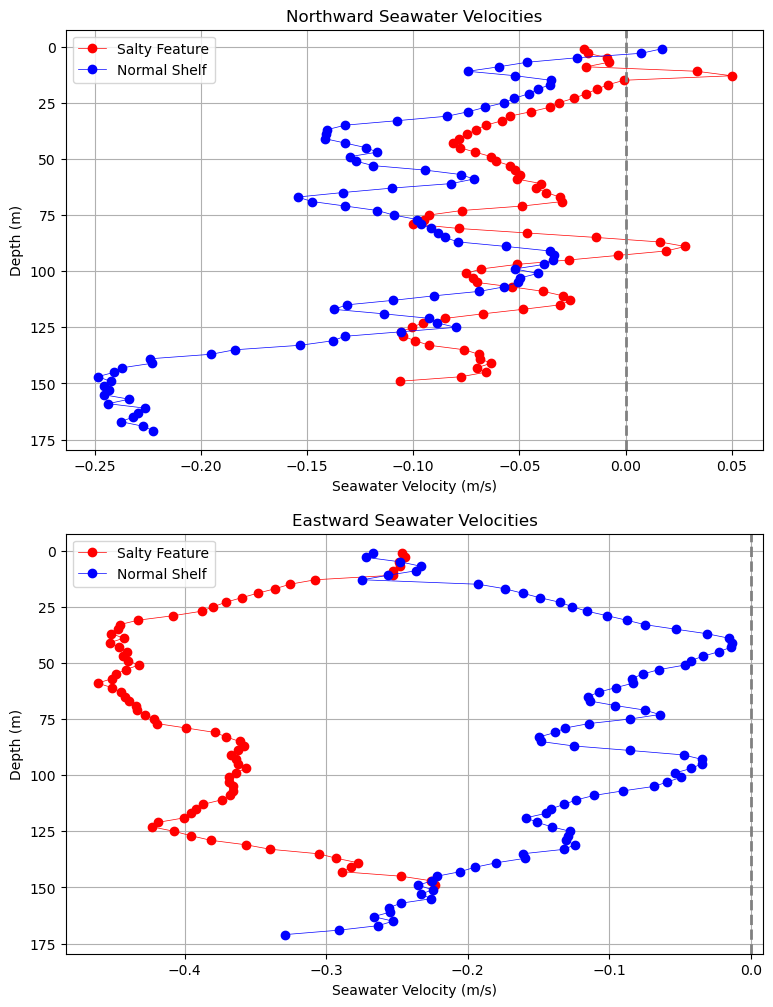

In [120]:
# plotting the northward velocities and eastward velocities together

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,12))
x1 = north_profile_salt
x2 = north_profile_shelf
x3 = east_profile_salt
x4 = east_profile_shelf
y1 =  bin_centers_salt
y2 = bin_centers_shelf

c1 = ax1.plot(x1, y1, label='Salty Feature', color='red', linewidth=0.5, marker='o')
ax1.plot(x2, y2, label='Normal Shelf', color='blue', linewidth=0.5, marker='o')
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=2)
ax1.set_ylabel('Depth (m)')
ax1.invert_yaxis()
ax1.set_xlabel('Seawater Velocity (m/s)')
ax1.set_title('Northward Seawater Velocities')
ax1.grid(True)
ax1.legend(loc='best')

c2 = ax2.plot(x3, y1, label='Salty Feature', color='red', marker='o', linewidth=0.5)
ax2.plot(x4, y2, label='Normal Shelf', color='blue', marker='o', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=2)
ax2.set_ylabel('Depth (m)')
ax2.invert_yaxis()
ax2.set_xlabel('Seawater Velocity (m/s)')
ax2.set_title('Eastward Seawater Velocities')
ax2.grid(True)
ax2.legend(loc='best')

plt.show()

**During the salt-water intrusion event, water velocities have a more northwestward flow. This may be indicative of a frontal meander. However, more data (like satellite SST data) would be needed to confirm this. Also, other segments, seasons, and gliders would need to be inspected to see if this signal is significant or not.**

## *Conclusions*

Quality control was successfully applied to the glider velocity data. This allowed us to:
- create depth-averaged velocity profiles of individual dives and over segments
- compare glider velocity data to mooring data
- possibly identify a plausible frontal meander of the shelf-break front